# Урок 8. Деревья решений.

В уроках мы разбирали на небольшом наборе данных деревья решений без настройки гиперпараметров. Здесь предлагаем вам рассмотреть работу классификатора на более сложном датасете, применив настройку гиперпараметров.

### 1.
На датасете из предыдущего урока - load_wine() - обучите дерево решений (DecisionTreeClassifier).

*Примечание: при установке гиперпараметров модели и разбиении на тренировочный и тестовый датасеты используйте random_state=17 для воспроизводимости результатов.*

In [67]:
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score

import pandas as pd
import graphviz

In [68]:
wine_dataset = load_wine()
wine_dataframe = pd.DataFrame(wine_dataset['data'], columns=wine_dataset.feature_names)

In [69]:
wine_dataframe.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

In [70]:
X = wine_dataframe
y = wine_dataset['target']

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=17)

In [71]:
dtc = DecisionTreeClassifier(random_state=17)
dtc_model = dtc.fit(x_train, y_train)

### 2.
Отобразите дерево с помощью библиотеки graphviz.

*Примечание: если, изучая урок, вы не установили библиотеку graphviz, то необходимо сделать это сейчас.*

In [72]:
def print_graph(data):
    dot_data = tree.export_graphviz(data, out_file=None,
                                    feature_names=wine_dataset.feature_names,
                                    class_names=wine_dataset.target_names,
                                    filled=True)
    return graphviz.Source(dot_data)

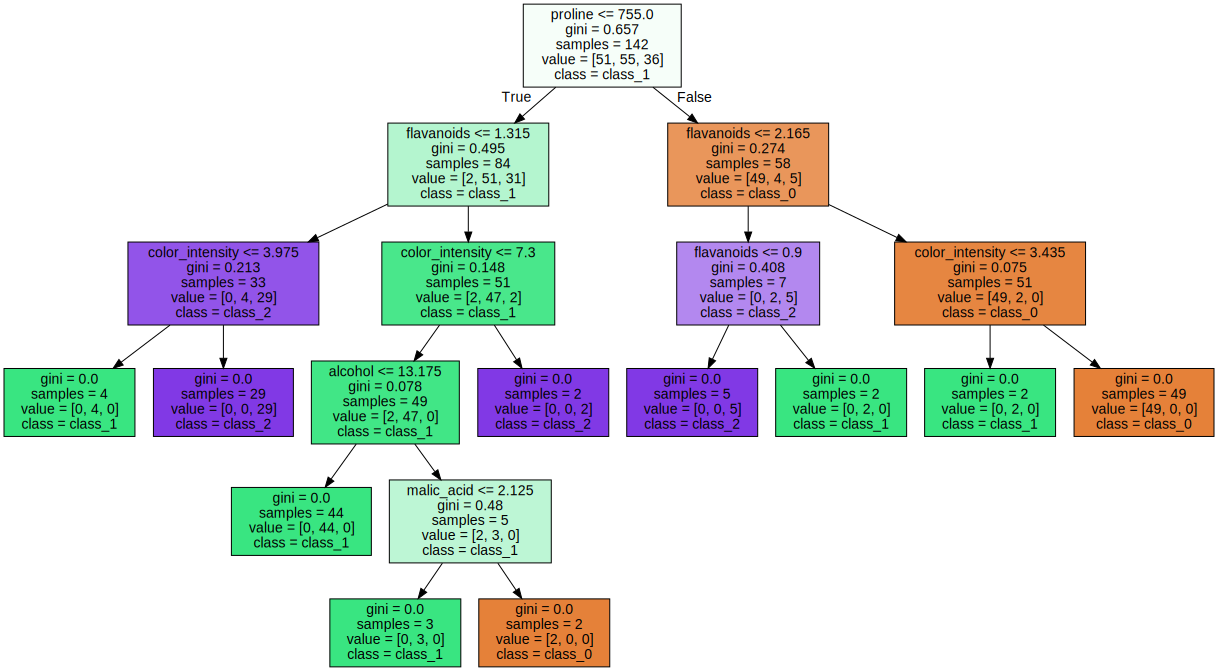

In [73]:
print_graph(dtc_model)

In [74]:
from graphviz import Digraph

dot = Digraph(comment='The Round Table')

dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')

dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')

print(dot.source)
dot.render('data/test_output/round_table.gv', view=True)


// The Round Table
digraph {
	A [label="King Arthur"]
	B [label="Sir Bedevere the Wise"]
	L [label="Sir Lancelot the Brave"]
	A -> B
	A -> L
	B -> L [constraint=false]
}



'data/test_output/round_table.gv.pdf'

### 3.
Используя полученную модель, сделайте прогноз для тестовой выборки данных и, пользуясь встроенной функцией score(), определите точность модели.

In [75]:
tc_predictions = dtc.predict(x_test)
tc_predictions

array([1, 1, 1, 0, 2, 2, 0, 1, 2, 0, 2, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1,
       0, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 0, 2, 1])

In [76]:
accuracy = dtc.score(x_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9722222222222222


Теперь попробуем сделать начальную настройку гиперпараметров и посмотреть, что из этого выйдет. 

### 4.

Постройте модель, указав гиперпараметр max_features равным 2 (так же указав random_state=17) и, сделав прогноз на тестовых данных, определите, стала ли модель работать точнее.

*Примечание: гиперпараметр max_features показывает модели, сколько различных признаков необходимо использовать каждый раз при принятии решения о разделении. То есть если, допустим, у вас имеются 50 признаков, а max_features=10, то в каждом узле случайным образом выбираются 10 признаков, которые будут использоваться для поиска лучшего разделения.*

In [77]:
dtc = DecisionTreeClassifier(max_features=2, random_state=17)
dtc_model2 = dtc.fit(x_train, y_train)

In [78]:
tc_predictions = dtc.predict(x_test)
tc_predictions


(process:43272): Gtk-WARNING **: 00:13:50.358: Locale not supported by C library.
	Using the fallback 'C' locale.


array([1, 1, 1, 0, 2, 2, 0, 1, 2, 0, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       0, 2, 1, 1, 0, 1, 2, 1, 2, 2, 0, 0, 2, 1])

In [79]:
accuracy = dtc.score(x_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9444444444444444


### 5.
Теперь постройте граф дерева решений, используя graphviz.

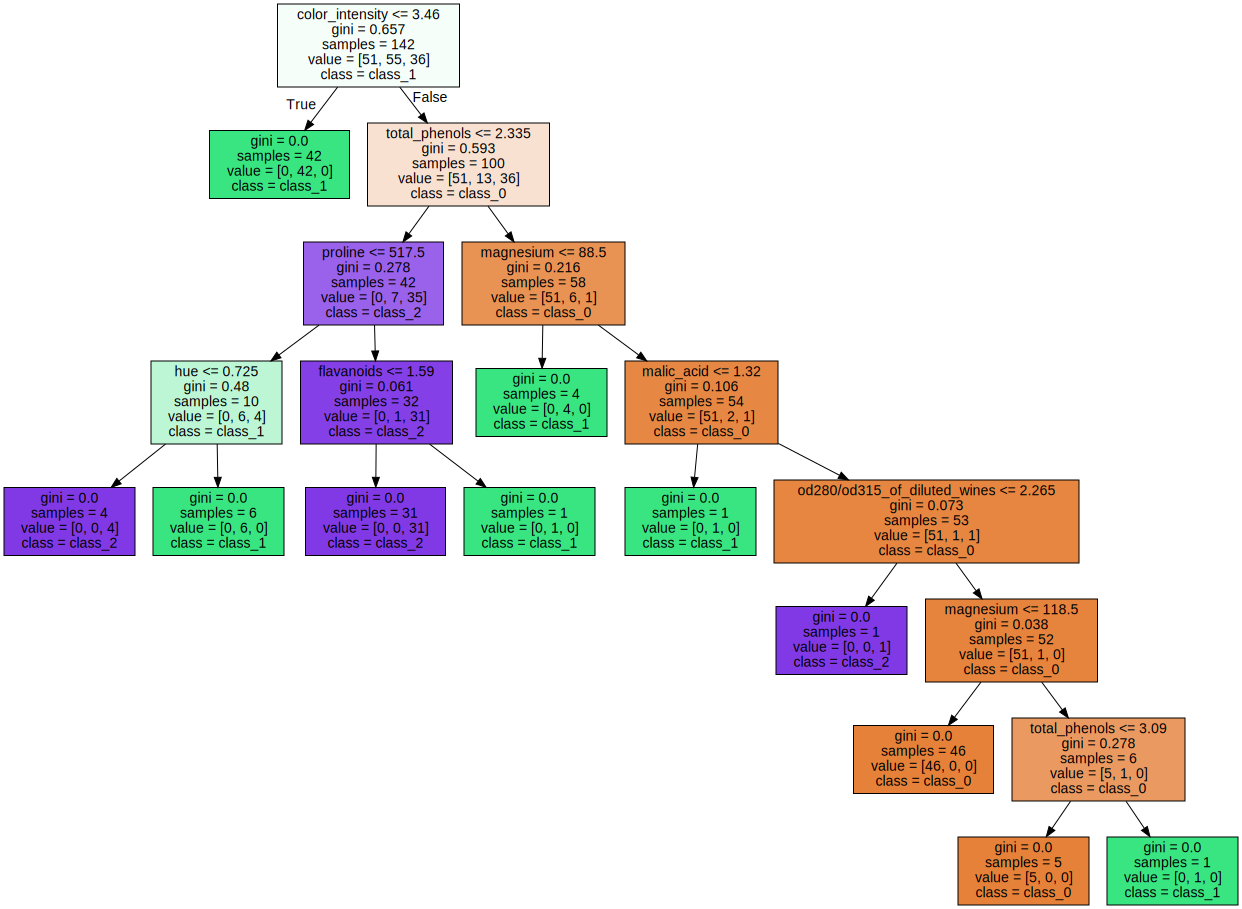

In [80]:
print_graph(dtc_model2)

Модель работает точнее, чем без настройки гиперпараметров, но по графу можно увидеть, что глубина дерева увеличилась, при этом в нескольких листах присутствует только по одному объекту, из-за чего на тестовом наборе данных дерево могло несколько потерять обобщающую способность.

Так как главная задача модели - способность обобщаться на новые данные, то для подбора оптимальных гиперпараметров надо пожертвовать небольшой порцией данных, чтобы на ней во время обучения проверять качество модели.

Часто для этого используют кросс-валидацию: модель обучается K раз на (K-1) подвыборках исходной выборки, а на одной подвыборке проверяется (каждый раз на разной). Получаются K оценок качества модели, которые обычно усредняются, давая среднюю оценку.

Кросс-валидация применяется для подбора гиперпараметров модели в методе GridSearchCV(): для каждой уникальной совокупности значений параметров проводится кросс-валидация и выбирается лучшее сочетание параметров.

### 6.
Используя обученное в предыдущем задании дерево решений, настройте параметры max_depth и max_features на 5-кратной валидации с помощью GridSearchCV. Для этого в функцию GridSearchCV передайте параметры (tree, tree_params, cv=5).

*Примечание: tree здесь - не обученная модель, а объект, который инкапсулирует алгоритм. Например, в уроке мы его обозначали как dtc.*

In [81]:
tree_params = {'max_depth': range(1, 6), 
               'max_features': range(1, 10)}

tree_grid = GridSearchCV(dtc, tree_params, cv=5)

### 7.
С помощью метода tree_grid.fit() постройте модель на тренировочных данных и выведите лучшее сочетание параметров с помощью метода tree_grid.best_params_.

In [82]:
tree_grid.fit(x_train, y_train)
print(f'Best params: {tree_grid.best_params_}')

Best params: {'max_depth': 5, 'max_features': 2}


### 8.
С помощью полученной модели сделайте прогноз - predict - для тестовой выборки и выведите долю верных ответов, проверив точность модели, используя функцию accuracy_score.

In [83]:
predicted = tree_grid.predict(x_test)
accuracy = accuracy_score(predicted, y_test)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9444444444444444
